In [27]:
!pip install pandas sqlalchemy matplotlib numpy


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine

# Database connection details
db_username = 'postgres'
db_password = 'Brainstorm99&&'
db_host = '127.0.0.1'
db_port = '5432'
db_name = 'Instacart_Analytics'

# Create a connection to the PostgreSQL database
engine = create_engine(f'postgresql+psycopg2://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}')

In [29]:
# Load data from tables into Pandas DataFrames
order_products__prior_df = pd.read_sql("SELECT * FROM public.order_products__prior", con=engine)
products_df = pd.read_sql("SELECT * FROM public.products", con=engine)
aisles_df = pd.read_sql("SELECT * FROM public.aisles", con=engine)
departments_df = pd.read_sql("SELECT * FROM public.departments", con=engine)

# Display the first few rows of each DataFrame to ensure data is loaded correctly
print(order_products__prior_df.head())
print(products_df.head())
print(aisles_df.head())
print(departments_df.head())


   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0
   product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13  
   aisle_id                       aisle
0         1       prepared soups salads
1         2  

In [30]:
# Merge order_products_prior with products to get product names and categories
merged_df = order_products_prior_df.merge(products_df, on='product_id').merge(aisles_df, on='aisle_id').merge(departments_df, on='department_id')
print(merged_df.head())

# Calculate the total number of purchases per aisle
purchases_per_aisle = merged_df.groupby('aisle_id')['order_id'].count().reset_index(name='total_purchases')
print(purchases_per_aisle.head())

# Calculate the number of reorder purchases per aisle
reorder_per_aisle = merged_df[merged_df['reordered'] == 1].groupby('aisle_id')['order_id'].count().reset_index(name='reorder_purchases')
print(reorder_per_aisle.head())

# Merge the two metrics
metrics_df = purchases_per_aisle.merge(reorder_per_aisle, on='aisle_id')
print(metrics_df.head())

# Calculate the percentage of reorder purchases
metrics_df['percent_reorder'] = (metrics_df['reorder_purchases'] / metrics_df['total_purchases']) * 100

# Add aisle names and department names to the metrics DataFrame
metrics_df = metrics_df.merge(aisles_df, on='aisle_id').merge(merged_df[['aisle_id', 'department_id']].drop_duplicates(), on='aisle_id').merge(departments_df, on='department_id')
print(metrics_df.head())


   order_id  product_id  add_to_cart_order  reordered           product_name  \
0         2       33120                  1          1     Organic Egg Whites   
1         2       28985                  2          1  Michigan Organic Kale   
2         2        9327                  3          0          Garlic Powder   
3         2       45918                  4          1         Coconut Butter   
4         2       30035                  5          0      Natural Sweetener   

   aisle_id  department_id               aisle  department  
0        86             16                eggs  dairy eggs  
1        83              4    fresh vegetables     produce  
2       104             13   spices seasonings      pantry  
3        19             13       oils vinegars      pantry  
4        17             13  baking ingredients      pantry  
   aisle_id  total_purchases
0         1            71928
1         2            82491
2         3           456386
3         4           200687
4       

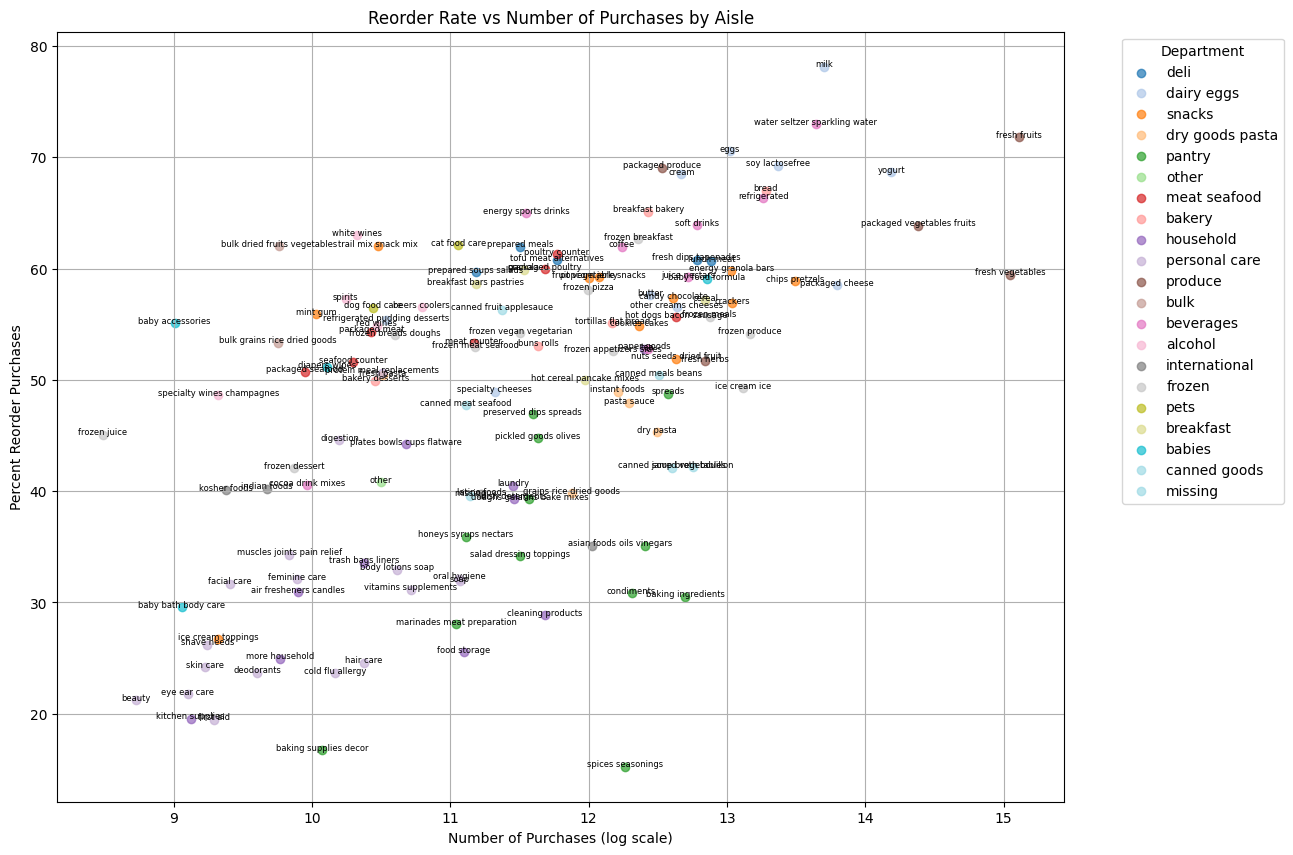

In [74]:
# Create a color map based on department_id
departments = metrics_df['department'].unique()
colors = plt.get_cmap('tab20', len(departments))

# Create scatter plot
plt.figure(figsize=(13, 10))

# Plot each point with a color based on the department
for i, department in enumerate(departments):
    department_data = metrics_df[metrics_df['department'] == department]
    plt.scatter(np.log1p(department_data['total_purchases']), department_data['percent_reorder'], alpha=0.7, color=colors(i), label=department)

# Annotate points with aisle names
for i, row in metrics_df.iterrows():
    plt.text(np.log1p(row['total_purchases']), row['percent_reorder'], row['aisle'], fontsize=6, ha='center')

plt.xlabel('Number of Purchases (log scale)')
plt.ylabel('Percent Reorder Purchases')
plt.title('Reorder Rate vs Number of Purchases by Aisle')

# Add a legend
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)
plt.show()
